:# CUSTOMER **SEGMENTATION** using RFM model

In [ ]:
 #Load FactSales
import pandas as pd

fact_sales = pd.read_csv('/content/FactSales.csv')
#Some factSales info
print("Shape of FactSales:", fact_sales.shape)
fact_sales.info()

Shape of FactSales: (70944, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70944 entries, 0 to 70943
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FactSalesKey           70944 non-null  int64  
 1   ProductKey             70944 non-null  int64  
 2   PromotionKey           70944 non-null  int64  
 3   CustomerKey            70944 non-null  int64  
 4   TerritoryKey           70944 non-null  int64  
 5   StoreKey               0 non-null      float64
 6   SalesReasonKey         64515 non-null  float64
 7   ShipMethodKey          70944 non-null  int64  
 8   SalesOrderID           70944 non-null  int64  
 9   SalesOrderDetail       70944 non-null  int64  
 10  OrderQty               70944 non-null  int64  
 11  UnitPrice              70944 non-null  float64
 12  UnitPriceDiscount      70944 non-null  float64
 13  OrderDateKey           70944 non-null  int64  
 14  DueDateKey            

In [ ]:
# --- Convert OrderDateKey to datetime ---
fact_sales['OrderDate'] = pd.to_datetime(fact_sales['OrderDateKey'], format='%Y%m%d', errors='coerce')

# Check for any conversion errors
fact_sales['OrderDate'].isnull().sum()

np.int64(0)

In [ ]:
# --- Convert OrderDateKey to datetime USE FOR FREQUENCY IN RFM model
fact_sales['OrderDate'] = pd.to_datetime(fact_sales['OrderDateKey'], format='%Y%m%d', errors='coerce')

# Check for any conversion errors
fact_sales['OrderDate'].isnull().sum()

np.int64(0)

In [ ]:
fact_sales[['LineAmount_Net', 'OrderQty', 'UnitPrice']].describe()
#check data

,LineAmount_Net,OrderQty,UnitPrice
count,70944.000000,70944.0,70944.000000
mean,532.604268,1.0,532.604268
std,1001.492256,0.0,1001.492256
min,2.290000,1.0,2.290000
25%,8.990000,1.0,8.990000
50%,29.990000,1.0,29.990000
75%,539.990000,1.0,539.990000
max,3578.270000,1.0,3578.270000


In [ ]:
#  Keep only necessary columns related to the RFM model
rfm_data = fact_sales[['CustomerKey', 'SalesOrderID', 'OrderDateKey', 'LineAmount_Net']].copy()

# Drop rows with missing data (if any)
rfm_data.dropna(subset=['CustomerKey', 'SalesOrderID', 'OrderDateKey', 'LineAmount_Net'], inplace=True)

# --- Convert OrderDateKey to datetime USE FOR FREQUENCY IN RFM model
rfm_data['OrderDate'] = pd.to_datetime(rfm_data['OrderDateKey'], format='%Y%m%d', errors='coerce')

# Remove rows with invalid dates (NaT)
rfm_data = rfm_data[~rfm_data['OrderDate'].isna()]

# Confirm result
rfm_data.info()
rfm_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70944 entries, 0 to 70943
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerKey     70944 non-null  int64         
 1   SalesOrderID    70944 non-null  int64         
 2   OrderDateKey    70944 non-null  int64         
 3   LineAmount_Net  70944 non-null  float64       
 4   OrderDate       70944 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.7 MB


,CustomerKey,SalesOrderID,OrderDateKey,LineAmount_Net,OrderDate
0,11396,59313,20131102,34.99,2013-11-02
1,11922,51920,20130630,24.99,2013-06-30
2,244,58636,20131025,8.99,2013-10-25
3,17174,58834,20131028,8.99,2013-10-28
4,6587,60389,20131118,28.99,2013-11-18


In [ ]:
# --- Compute RFM metrics per customer

# Step 1: Get the most recent order date in the whole dataset
latest_date = rfm_data['OrderDate'].max()
print("Most recent order date in dataset:", latest_date)

# Step 2: Group by customer and compute R, F, M
rfm = rfm_data.groupby('CustomerKey').agg({
    'OrderDate': lambda x: (latest_date - x.max()).days,  # Recency
    'SalesOrderID': 'nunique',                           # Frequency
    'LineAmount_Net': 'sum'                              # Monetary
}).reset_index()

# Rename columns for clarity
rfm.rename(columns={'OrderDate': 'Recency',
                    'SalesOrderID': 'Frequency',
                    'LineAmount_Net': 'Monetary'}, inplace=True)

# Show sample
rfm.head()


Most recent order date in dataset: 2014-06-30 00:00:00


,CustomerKey,Recency,Frequency,Monetary
0,1,334,1,83.9700
1,2,33,3,41.2600
2,3,174,3,10564.9600
3,4,132,2,3150.3982
4,5,241,2,8911.5200


In [ ]:
#  Assign R, F, M scores (1 to 5)

# For Recency, lower = better (recent buyers get higher score)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# For Frequency and Monetary, higher = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine into one RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm.head()

,CustomerKey,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1,334,1,83.9700,1,1,2,112
1,2,33,3,41.2600,5,5,2,552
2,3,174,3,10564.9600,3,5,5,355
3,4,132,2,3150.3982,4,4,4,444
4,5,241,2,8911.5200,2,4,5,245


In [ ]:
#  Define RFM segment labels
def segment_customer(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 4:
        return 'Loyal'
    elif r >= 4 and f <= 2:
        return 'Potential'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    else:
        return 'Dormant'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm.head(10)

,CustomerKey,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,1,334,1,83.9700,1,1,2,112,Dormant
1,2,33,3,41.2600,5,5,2,552,Loyal
2,3,174,3,10564.9600,3,5,5,355,Loyal
3,4,132,2,3150.3982,4,4,4,444,Champions
4,5,241,2,8911.5200,2,4,5,245,At Risk
5,6,37,2,2994.0882,5,4,4,544,Champions
6,7,276,1,1750.9800,2,1,4,214,Dormant
7,8,15,1,64.4700,5,1,2,512,Potential
8,9,354,1,42.2800,1,1,2,112,Dormant
9,10,180,1,4.9900,3,1,1,311,Dormant


     Segment  CustomerCount     Monetary  Frequency     Recency
2    Dormant           6745   731.928450   1.000000  232.378503
0    At Risk           4036  3134.195063   1.576561  304.855550
3      Loyal           2939  2346.379627   2.326642  118.649541
4  Potential           2661   629.297704   1.000000   70.680571
1  Champions           2103  5529.261811   2.402282   78.477889


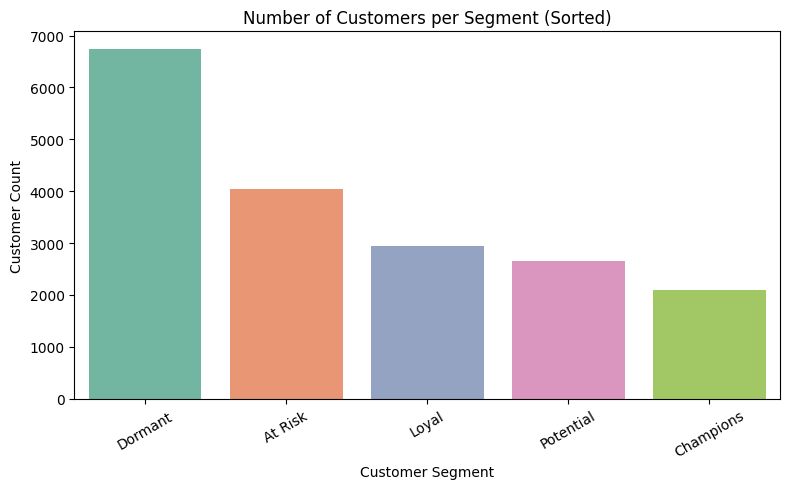

In [ ]:
# --------------------------------------------
# ✅ Analyze segment sizes and values (sorted)
# --------------------------------------------

# Count customers per segment
segment_summary = rfm.groupby('Segment').agg({
    'CustomerKey': 'count',
    'Monetary': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean'
}).rename(columns={'CustomerKey': 'CustomerCount'}).reset_index()

# 🟩 Sort by CustomerCount (descending)
segment_summary = segment_summary.sort_values(by='CustomerCount', ascending=False)

# Display summary table
print(segment_summary)

# --------------------------------------------
# 📊 Plot: Number of Customers per Segment
# --------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(
    data=segment_summary,
    x='Segment',
    y='CustomerCount',
    hue='Segment',
    palette='Set2',
    legend=False
)

plt.title('Number of Customers per Segment (Sorted)')
plt.xlabel('Customer Segment')
plt.ylabel('Customer Count')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [ ]:
rfm.to_csv('/content/Customer_RFM_Segments.csv', index=False)
print("✅ RFM segmentation file saved successfully!")

✅ RFM segmentation file saved successfully!


PHASE 2: PROMOTION SEGMENTATION BASED ON THE CUSTOMER SEGMENTATION

**Data handling**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load datasets
fact_sales = pd.read_csv('/content/FactSales.csv')
dim_promotion = pd.read_csv('/content/DimPromotion.csv')
dim_product = pd.read_csv('/content/DimProduct.csv')
rfm_segments = pd.read_csv('/content/Customer_RFM_Segments.csv')
dim_teritory = pd.read_csv('/content/DimTerritory.csv')
# Quick checks
print("✅ Files loaded successfully")
print("FactSales:", fact_sales.shape)
print("DimPromotion:", dim_promotion.shape)
print("DimProduct:", dim_product.shape)
print("RFM Segments:", rfm_segments.shape)
print("DimTerritory:", dim_teritory.shape)




✅ Files loaded successfully
FactSales: (70944, 27)
DimPromotion: (16, 11)
DimProduct: (504, 15)
RFM Segments: (18484, 9)
DimSalesReason: (27647, 6)
DimTerritory: (10, 11)


In [ ]:
# Select important columns
fact_sales = fact_sales[['CustomerKey','SalesOrderID', 'ProductKey','TerritoryKey', 'PromotionKey', 'OrderQty',
                         'LineAmount_Net', 'OrderDateKey']]
#FactSales: transaction-level details to calculate profit and link customers, products, and promotions.
dim_promotion = dim_promotion[['PromotionKey', 'Description', 'Type',
                               'DiscountPct', 'StartDate', 'EndDate']]
#DimPromotion: promotion characteristics (type, category, discount, timing).
dim_product = dim_product[['ProductKey', 'StandardCost', 'ListPrice']]
#DimProduct: product cost and price for profit calculation.
rfm_segments = rfm_segments[['CustomerKey', 'Segment']]
#rfm_segments: customer behavioral segment from RFM model.

dim_teritory = dim_teritory[['TerritoryID', 'Group']]



# Quick peek
dim_teritory.head()
#By merging these, every sales record now includes who bought (segment), what they bought (product),
#under which promotion (type/category), and how profitable it was — forming the foundation for both customer and promotion analysis.

,TerritoryID,Group
0,1,North America
1,2,North America
2,3,North America
3,4,North America
4,5,North America


In [ ]:
# --- STEP 3: Merge tables ---

# Merge FactSales with Promotion info
merged_df = fact_sales.merge(
    dim_promotion[['PromotionKey', 'Description','Type', 'DiscountPct', 'StartDate', 'EndDate']],
    on='PromotionKey', how='left'
)

# Merge with Product info to get cost
merged_df = merged_df.merge(dim_product, on='ProductKey', how='left')

# Merge with customer RFM segments
merged_df = merged_df.merge(rfm_segments, on='CustomerKey', how='left')

print("✅ Merged dataset shape:", merged_df.shape)
# Merge with Territory info
merged_df = merged_df.merge(dim_teritory.rename(columns={'TerritoryID': 'TerritoryKey'}), on='TerritoryKey', how='left')

# Merge with Product info to get cost
#sort only related to promo
merged_df = merged_df[merged_df['Type'] != 'No Discount']

merged_df.head()
#By merging these, every sales record now includes who bought (segment), what they bought (product),
#under which promotion (type/category), and how profitable it was — forming the foundation for both customer and promotion analysis.

✅ Merged dataset shape: (70944, 16)


,CustomerKey,SalesOrderID,ProductKey,TerritoryKey,PromotionKey,OrderQty,LineAmount_Net,OrderDateKey,Description,Type,DiscountPct,StartDate,EndDate,StandardCost,ListPrice,Segment,Group
9,13297,64106,284,9,2,1,2319.99,20140112,Volume Discount 11 to 14,Volume Discount,0.02,2011-05-31 00:00:00,2014-05-30 00:00:00,1265.6195,2319.99,Loyal,Pacific
32,2656,72863,284,8,2,1,2319.99,20140514,Volume Discount 11 to 14,Volume Discount,0.02,2011-05-31 00:00:00,2014-05-30 00:00:00,1265.6195,2319.99,Potential,Europe
38,5660,64603,379,1,2,1,8.99,20140119,Volume Discount 11 to 14,Volume Discount,0.02,2011-05-31 00:00:00,2014-05-30 00:00:00,3.3623,8.99,Loyal,North America
113,10895,50141,295,9,2,1,2443.35,20130324,Volume Discount 11 to 14,Volume Discount,0.02,2011-05-31 00:00:00,2014-05-30 00:00:00,1518.7864,2443.35,Loyal,Pacific
184,13910,62603,378,4,2,1,2.29,20131222,Volume Discount 11 to 14,Volume Discount,0.02,2011-05-31 00:00:00,2014-05-30 00:00:00,0.8565,2.29,Dormant,North America


In [ ]:
# --- STEP 4: Calculate Profit ---

merged_df['Profit'] = merged_df['LineAmount_Net'] - (merged_df['OrderQty'] * merged_df['StandardCost'])
#Profit=LineAmount_Net−(OrderQty×StandardCost)
#This calculates how much money the company earns per sale after subtracting product cost.
# Check for negative or null values
print("Negative Profit Rows:", (merged_df['Profit'] < 0).sum())
merged_df[['LineAmount_Net', 'OrderQty', 'StandardCost', 'Profit']].head()


Negative Profit Rows: 0


,LineAmount_Net,OrderQty,StandardCost,Profit
9,2319.99,1,1265.6195,1054.3705
32,2319.99,1,1265.6195,1054.3705
38,8.99,1,3.3623,5.6277
113,2443.35,1,1518.7864,924.5636
184,2.29,1,0.8565,1.4335


In [ ]:
#  Convert OrderDateKey and add time features ---
merged_df['OrderDate'] = pd.to_datetime(merged_df['OrderDateKey'], format='%Y%m%d', errors='coerce')
merged_df['Month'] = merged_df['OrderDate'].dt.month
merged_df['Year'] = merged_df['OrderDate'].dt.year

# Define seasons, Creates a Season column (Winter, Spring, Summer, Fall)
#so you can later measure which seasons or periods generate higher profits or promotion effectiveness.
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged_df['Season'] = merged_df['Month'].apply(get_season)

merged_df[['OrderDate', 'Month', 'Year', 'Season']].head()


,OrderDate,Month,Year,Season
9,2014-01-12,1,2014,Winter
32,2014-05-14,5,2014,Spring
38,2014-01-19,1,2014,Winter
113,2013-03-24,3,2013,Spring
184,2013-12-22,12,2013,Winter


In [ ]:
# --- STEP 7: Check missing values and summary ---
print("Missing values per column:\n", merged_df.isnull().sum())
print(merged_df[['Profit', 'DiscountPct', 'OrderQty']].describe())


Missing values per column:
 CustomerKey       0
SalesOrderID      0
ProductKey        0
TerritoryKey      0
PromotionKey      0
OrderQty          0
LineAmount_Net    0
OrderDateKey      0
Description       0
Type              0
DiscountPct       0
StartDate         0
EndDate           0
StandardCost      0
ListPrice         0
Segment           0
Group             0
Profit            0
OrderDate         0
Month             0
Year              0
Season            0
dtype: int64
            Profit  DiscountPct  OrderQty
count  3115.000000  3115.000000    3115.0
mean    375.321715     0.022796       1.0
std     432.204856     0.020759       0.0
min       1.433500     0.020000       1.0
25%       1.433500     0.020000       1.0
50%     196.340400     0.020000       1.0
75%     888.402100     0.020000       1.0
max    1054.370500     0.200000       1.0


In [ ]:
# print("Unique values in 'Group':")
# print(merged_df['Group'].unique())
# print("\nNumber of unique groups:", merged_df['Group'].nunique())

merged_df['Description'].value_counts()


,count
Description,
Volume Discount 11 to 14,3058
Touring-3000 Promotion,31
Touring-1000 Promotion,26


In [ ]:
#  Final dataset preview
merged_df.head()

print("✅ Final dataset ready for Promotion Effectiveness Analysis!")
print("Columns available:\n", merged_df.columns.tolist())


✅ Final dataset ready for Promotion Effectiveness Analysis!
Columns available:
 ['CustomerKey', 'SalesOrderID', 'ProductKey', 'TerritoryKey', 'PromotionKey', 'OrderQty', 'LineAmount_Net', 'OrderDateKey', 'Description', 'Type', 'DiscountPct', 'StartDate', 'EndDate', 'StandardCost', 'ListPrice', 'Segment', 'Group', 'Profit', 'OrderDate', 'Month', 'Year', 'Season']


# ** Phase 2: Promotion Segmentation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Total Profit = revenue minus total cost

Profit
=
LineAmount_Net
−
(
StandardCost
×
OrderQty
)
Profit=LineAmount_Net−(StandardCost×OrderQty)

So if a product costs $50 to make and sells for $80 (OrderQty = 2):

80
−
(
50
×
2
)
=
−
20
⇒
(loss of $20)
80−(50×2)=−20⇒(loss of $20)

Profit per unit = how much profit you make per item sold

Profit_per_unit
=
Profit
OrderQty
Profit_per_unit=
OrderQty
Profit
	​
This applies a logarithmic transformation to the profit per unit:

log_profit_unit
=
ln
⁡
(
1
+
Profit_per_unit
)
log_profit_unit=ln(1+Profit_per_unit)
->purpose:
Reduces skewness (normalizes the distribution),

Makes differences more proportional,

Prevents negative or zero profit from causing math errors (log1p handles 0 safely).

Now you pull out the coefficients (weights) from the trained model.

Each coefficient shows how much that variable impacts log_profit_unit,
while holding others constant.

**Interpretation rule**

Positive coefficient → increases profit per unit.

Negative coefficient → decreases profit per unit.

Magnitude → strength of the effect.

different approach

Which customer segments benefit most from promotions? -> Focuses on who to propose promotions to.

What’s the best timing for promotions?->Focuses on when to propose promotions.

Which segment–promotion combinations perform best?->Focuses on what type of proposal works for each customer group.

In [ ]:
# --- STEP 1: Keep only promotional transactions --- approach2
df = merged_df.copy()
# Recalculate profit and per-unit profit
df['Profit'] = df['LineAmount_Net'] - (df['OrderQty'] * df['StandardCost'])
df['Profit_per_unit'] = df['Profit'] / np.maximum(df['OrderQty'], 1)

# Winsorize to remove extreme outliers (1%)
from scipy.stats.mstats import winsorize
df['Profit_per_unit'] = winsorize(df['Profit_per_unit'], limits=[0.01, 0.01])

# Log-transform to stabilize variance
df['log_profit_unit'] = np.log1p(df['Profit_per_unit'])


print(" Promotions included:", df['Description'].unique())
print(" Shape after filtering:", df.shape)


✅ Promotions included: ['Volume Discount 11 to 14' 'Touring-3000 Promotion'
 'Touring-1000 Promotion']
✅ Shape after filtering: (3115, 24)


defining the actual regression model — Ridge Regression.

Ridge Regression = a type of linear regression that adds a penalty for large coefficients.

Helps prevent overfitting (where the model memorizes noise instead of learning patterns).

Formula:

min
⁡
∣
∣
𝑦
−
𝑋
𝛽
∣
∣
2
+
𝛼
∣
∣
𝛽
∣
∣
2
min∣∣y−Xβ∣∣
2
+α∣∣β∣∣
2

where α (alpha) controls how strong the penalty is.

RidgeCV automatically tests 20 different alpha values between 0.01 and 100 (np.logspace(-2, 2, 20)),
and picks the one with best performance through 5-fold cross-validation (cv=5).
->This ensures your model is stable, smooth, and resistant to overfitting, especially with many categorical features.

In [ ]:
combo_counts = df.groupby(['Segment', 'Description']).size().reset_index(name='count')
display(combo_counts.sort_values(by='count', ascending=False))

# Keep reliable pairs only
valid_combos = combo_counts[combo_counts['count'] >= 50]
df = df.merge(valid_combos[['Segment', 'Description']], on=['Segment', 'Description'], how='inner')

print("✅ Valid segment–promotion pairs retained:", df['Description'].nunique(), "promotions across", df['Segment'].nunique(), "segments")


,Segment,Description,count
8,Dormant,Volume Discount 11 to 14,759
2,At Risk,Volume Discount 11 to 14,710
5,Champions,Volume Discount 11 to 14,675
11,Loyal,Volume Discount 11 to 14,630
12,Potential,Volume Discount 11 to 14,284
0,At Risk,Touring-1000 Promotion,12
7,Dormant,Touring-3000 Promotion,11
1,At Risk,Touring-3000 Promotion,11
6,Dormant,Touring-1000 Promotion,10
10,Loyal,Touring-3000 Promotion,7


✅ Valid segment–promotion pairs retained: 1 promotions across 5 segments


In [ ]:
df['Segment_Description'] = df['Segment'] + ' | ' + df['Description']
display(df[['Segment', 'Description', 'Segment_Description']].head(10))


,Segment,Description,Segment_Description
0,Loyal,Volume Discount 11 to 14,Loyal | Volume Discount 11 to 14
1,Potential,Volume Discount 11 to 14,Potential | Volume Discount 11 to 14
2,Loyal,Volume Discount 11 to 14,Loyal | Volume Discount 11 to 14
3,Loyal,Volume Discount 11 to 14,Loyal | Volume Discount 11 to 14
4,Dormant,Volume Discount 11 to 14,Dormant | Volume Discount 11 to 14
5,At Risk,Volume Discount 11 to 14,At Risk | Volume Discount 11 to 14
6,Potential,Volume Discount 11 to 14,Potential | Volume Discount 11 to 14
7,Champions,Volume Discount 11 to 14,Champions | Volume Discount 11 to 14
8,Champions,Volume Discount 11 to 14,Champions | Volume Discount 11 to 14
9,Champions,Volume Discount 11 to 14,Champions | Volume Discount 11 to 14


In [ ]:
X = df[['Segment',  'Season', 'StandardCost', 'OrderQty', 'Segment_Description', 'Group']]
#X (features) are the business factors that might explain why profit per unit goes up or down under different promotions.
#Controls: StandardCost, OrderQty (to avoid confusing price/cost mix with promo effect)
y = df['log_profit_unit']

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
import numpy as np

# Features
numeric_features = ['StandardCost', 'OrderQty']
categorical_features = ['Segment', 'Season', 'Group']

# 1️⃣ Main categorical encoder (with manually set baselines)
categorical_transformer = OneHotEncoder(
    categories=[
        ['Dormant', 'At Risk', 'Loyal', 'Potential', 'Champions'],  # Segment baseline = Dormant
        ['Summer', 'Spring', 'Winter', 'Fall'],                     # Season baseline = Summer
        ['Europe','North America', 'Pacific']                      # Group baseline = North America
    ],
    drop='first',
    handle_unknown='ignore'
)

# 2️⃣ Encoder for the combo column
cat_encoder_combo = OneHotEncoder(drop='first', handle_unknown='ignore')

# 3️⃣ Numeric transformer
numeric_transformer = StandardScaler()

# 4️⃣ Combine everything into one preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('cat_combo', cat_encoder_combo, ['Segment_Description'])
])

# 5️⃣ Ridge regression model with CV
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=np.logspace(-2, 2, 20), cv=5))
])

# ✅ Fit the model
model.fit(X, y)
print("✅ Model trained successfully!")


✅ Model trained successfully!


Ridge Regression (with CV) for stability and to reduce overfitting/multicollinearity.
OneHotEncoder: turn categories (like seasons or customer segments) into numbers.
if we include all categories, it causes something called multicollinearity —>  the model can’t tell which variable truly affects the outcome because they overlap perfectly.
-> drop one category in each group — this is called the baseline.

In [ ]:
# ---------------------------------------------
# Coefficient Extraction (fixed for multiple encoders)
# ---------------------------------------------
feature_names_num = numeric_features

# get names from both encoders
feature_names_cat = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names_combo = model.named_steps['preprocessor'].named_transformers_['cat_combo'].get_feature_names_out(['Segment_Description'])

# combine all
all_features = np.concatenate([feature_names_num, feature_names_cat, feature_names_combo])

# coefficients
coef = model.named_steps['regressor'].coef_

# now they should match perfectly
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coef
}).sort_values(by='Coefficient', ascending=False)
season_df = coef_df[coef_df['Feature'].str.contains('Season_', case=False)]
territory_df = coef_df[coef_df['Feature'].str.contains('Group_', case=False)]
display(coef_df.head(15))
season_df
promotion_segment_df = coef_df[coef_df['Feature'].str.contains('Segment_Description_', case=False)]
display(promotion_segment_df)
display(territory_df)
display(season_df)




,Feature,Coefficient
0,StandardCost,2.417232
7,Season_Winter,0.228400
6,Season_Spring,0.208067
8,Season_Fall,0.134422
11,Segment_Description_Champions | Volume Discoun...,0.097039
5,Segment_Champions,0.097039
2,Segment_At Risk,0.074105
9,Group_North America,0.071239
10,Group_Pacific,0.023110
1,OrderQty,0.000000


,Feature,Coefficient
11,Segment_Description_Champions | Volume Discoun...,0.097039
14,Segment_Description_Potential | Volume Discoun...,-0.023318
12,Segment_Description_Dormant | Volume Discount ...,-0.054182
13,Segment_Description_Loyal | Volume Discount 11...,-0.093643


,Feature,Coefficient
9,Group_North America,0.071239
10,Group_Pacific,0.023110


,Feature,Coefficient
7,Season_Winter,0.228400
6,Season_Spring,0.208067
8,Season_Fall,0.134422


Profitability is seasonally strongest in Winter and Spring.

North American markets deliver higher per-unit profit.

Promotional effectiveness varies across customer segments, with Champions being the most profitable under volume discounts.

A negative coefficient means “less effective than baseline.” It does not mean the campaign loses money by itself; it means the incremental profit/unit is weaker

Export to put in POWER **BI**

In [ ]:
# If rfm (or rfm_segments joined to recency/frequency/monetary) is available:
rfm_summary = rfm.groupby('Segment', as_index=False).agg(
    CustomerCount=('CustomerKey','count'),
    Monetary=('Monetary','mean'),
    Frequency=('Frequency','mean'),
    Recency=('Recency','mean')
)
rfm_summary.to_csv('/content/rfm_summary.csv', index=False)
print('Saved: /content/rfm_summary.csv  ->', rfm_summary.shape)


Saved: /content/rfm_summary.csv  -> (5, 5)


In [ ]:
# --- Step 1: Extract season & group coefficients ---

# your model coefficient dataframe
coef_df = coef_df[['Feature', 'Coefficient']].copy()

# categorize them manually
coef_df['Category'] = coef_df['Feature'].apply(
    lambda x: 'Season' if 'Season' in x else
              'Group' if 'Group' in x else
              None
)

# filter out the ones you care about
impact_df = coef_df[coef_df['Category'].isin(['Season', 'Group'])].copy()

# optional: compute uplift (%)
import numpy as np
impact_df['Uplift(%)'] = np.round((np.exp(impact_df['Coefficient']) - 1) * 100, 2)

# save to CSV
impact_df.to_csv('/content/Promotion_Impact_Season_Group.csv', index=False)
print("✅ Exported to /content/Promotion_Impact_Season_Group.csv")
impact_df


✅ Exported to /content/Promotion_Impact_Season_Group.csv


,Feature,Coefficient,Category,Uplift(%)
7,Season_Winter,0.227735,Season,25.58
6,Season_Spring,0.207029,Season,23.00
8,Season_Fall,0.134451,Season,14.39
9,Group_North America,0.071196,Group,7.38
10,Group_Pacific,0.023065,Group,2.33


In [ ]:
# --- Clean up Feature names for Power BI ---

# Filter coef_df to only include Segment_Description features
combo_df = coef_df[coef_df['Feature'].str.contains('Segment_Description_', case=False)].copy()

def shorten_feature_name(x):
    # Remove redundant technical prefixes
    x = x.replace("Segment_Description_", "")
    x = x.replace("| Volume Discount 11 to 14", "")
    x = x.replace("_", " ")  # replace underscores with spaces
    return x.strip()

# Apply the cleaner naming
combo_df['Short Feature'] = combo_df['Feature'].apply(shorten_feature_name)

# Compute Uplift (%) for the filtered data
combo_df['Uplift(%)'] = np.round((np.exp(combo_df['Coefficient']) - 1) * 100, 2)


# Keep only relevant columns
combo_df_clean = combo_df[['Short Feature', 'Coefficient', 'Uplift(%)']].copy()

# Rename columns for Power BI readability
combo_df_clean.rename(columns={
    'Short Feature': 'Customer Segment',
    'Coefficient': 'Model Coefficient',
    'Uplift(%)': 'Profit Uplift (%)'
}, inplace=True)

# Export cleaned CSV
output_path = '/content/Promotion_Segment_Impact.csv'
combo_df_clean.to_csv(output_path, index=False)

print(f"✅ Exported clean file to {output_path}")
combo_df_clean.head()

✅ Exported clean file to /content/Promotion_Segment_Impact.csv


,Customer Segment,Model Coefficient,Profit Uplift (%)
11,Champions,0.097039,10.19
14,Potential,-0.023318,-2.30
12,Dormant,-0.054182,-5.27
13,Loyal,-0.093643,-8.94


In [ ]:
# --- FIND A 2-ITEM COMBO ---
print("\n--- Part 2: Finding a 2-Item Combo ---")
try:
    df_sales_co = pd.read_csv("/content/FactSales.csv")
    df_product_co = pd.read_csv("/content/DimProduct.csv")

    sales_products = df_sales_co[['SalesOrderID', 'ProductKey']]
    product_names = df_product_co[['ProductKey', 'Name']]
    basket_data = pd.merge(sales_products, product_names, on='ProductKey')

    order_sizes = basket_data.groupby('SalesOrderID').size()
    multi_item_orders = order_sizes[order_sizes > 1].index
    multi_item_basket_data = basket_data[basket_data['SalesOrderID'].isin(multi_item_orders)]

    merged_baskets = pd.merge(multi_item_basket_data, multi_item_basket_data, on='SalesOrderID')
    co_occurrence = merged_baskets[merged_baskets['ProductKey_x'] < merged_baskets['ProductKey_y']]
    pair_counts = co_occurrence.groupby(['Name_x', 'Name_y']).size().reset_index(name='PurchaseCount')

    df_pairs = pair_counts.sort_values(by='PurchaseCount', ascending=False)

    # --- Print the analysis table ---
    print("\n--- Top 10 Most Frequent 2-Item Combos (Ranked by Support) ---")
    print(df_pairs.head(10).to_string())

    # Get the top pair (A, B)
    top_pair = df_pairs.iloc[0]
    item_A = top_pair['Name_x']
    item_B = top_pair['Name_y']

    BUNDLE_PRODUCT_NAMES = [item_A, item_B]
    print(f"\nSuccessfully identified #1 combo for simulation: {BUNDLE_PRODUCT_NAMES}")

except Exception as e:
    print(f"Error finding 2-item combo: {e}. Using a manually defined combo.")
    BUNDLE_PRODUCT_NAMES = ["Water Bottle - 30 oz.", "Road Bottle Cage"]
    print(f"Using manual combo: {BUNDLE_PRODUCT_NAMES}")



--- Part 2: Finding a 2-Item Combo ---

--- Top 10 Most Frequent 2-Item Combos (Ranked by Support) ---
                     Name_x                 Name_y  PurchaseCount
1971  Water Bottle - 30 oz.       Road Bottle Cage           3618
1952  Water Bottle - 30 oz.   Mountain Bottle Cage           2295
903      Mountain Tire Tube       LL Mountain Tire           1315
902      Mountain Tire Tube       HL Mountain Tire           1242
1062    Patch Kit/8 Patches     Mountain Tire Tube           1206
904      Mountain Tire Tube       ML Mountain Tire           1011
1921      Touring Tire Tube           Touring Tire           1002
86             AWC Logo Cap  Water Bottle - 30 oz.            911
1060    Patch Kit/8 Patches       ML Mountain Tire            805
1240         Road Tire Tube           ML Road Tire            789

Successfully identified #1 combo for simulation: ['Water Bottle - 30 oz.', 'Road Bottle Cage']


In [ ]:
# --- CLUSTER-SPECIFIC PROFIT SIMULATION ---
print("\n--- Part 3: Running Cluster-Specific Profit Simulation ---")

# Define our prediction (Elasticity)
PRICE_ELASTICITY_ESTIMATE = -2.5
print(f"Using Price Elasticity = {PRICE_ELASTICITY_ESTIMATE} (A 10% discount predicts a 25% sales lift)")

try:
    # --- 3.1. Find the Target Customer Cluster ---
    df_product = pd.read_csv("/content/DimProduct.csv")
    df_sales = pd.read_csv("/content/FactSales.csv")

    # Get the ProductKeys for our combo
    bundle_items_details = df_product[df_product['Name'].isin(BUNDLE_PRODUCT_NAMES)]
    bundle_product_keys = bundle_items_details['ProductKey'].tolist()

    # Merge sales with segment data (from Part 1)
    df_sales_segmented = pd.merge(df_sales, rfm[['CustomerKey', 'Segment']], on='CustomerKey')

    # Filter sales for only the products in our bundle
    df_bundle_item_sales = df_sales_segmented[df_sales_segmented['ProductKey'].isin(bundle_product_keys)]

    if df_bundle_item_sales.empty:
        raise Exception(f"No sales found for any items in this bundle: {BUNDLE_PRODUCT_NAMES}")

    # Analyze which cluster buys these items the most
    cluster_affinity = df_bundle_item_sales.groupby('Segment')['OrderQty'].sum().sort_values(ascending=False)
    target_cluster = cluster_affinity.idxmax()

    print("\nPurchase Affinity for Bundle Items:")
    print(cluster_affinity)
    print(f"\nTarget Cluster identified: '{target_cluster}'")

    # --- 3.2. Calculate Cluster-Specific Baseline ---
    print(f"Calculating baseline for Target Cluster: '{target_cluster}'")

    baseline_bundle_list_price = bundle_items_details['ListPrice'].sum()
    baseline_bundle_cost = bundle_items_details['StandardCost'].sum()

    # Get all sales related to these items, for this cluster only
    df_cluster_sales = df_bundle_item_sales[df_bundle_item_sales['Segment'] == target_cluster]

    total_baseline_profit = 0
    total_baseline_revenue = 0
    total_baseline_discount_given = 0
    total_baseline_gross = 0

    for pk in bundle_product_keys:
        item_sales = df_cluster_sales[df_cluster_sales['ProductKey'] == pk]
        item_cost = 0.0
        if pk in bundle_items_details['ProductKey'].values:
            cost_val = bundle_items_details[bundle_items_details['ProductKey'] == pk]['StandardCost'].values
            if len(cost_val) > 0:
                item_cost = cost_val[0]

        item_qty = item_sales['OrderQty'].sum()
        item_revenue = item_sales['LineAmount_Net'].sum()
        item_gross_amt = item_sales['LineAmount_Gross'].sum()

        total_baseline_profit += item_revenue - (item_qty * item_cost)
        total_baseline_revenue += item_revenue
        if item_gross_amt > 0:
            total_baseline_discount_given += item_gross_amt - item_revenue
            total_baseline_gross += item_gross_amt
        else:
             total_baseline_gross += item_revenue

    if total_baseline_gross > 0:
        baseline_avg_discount_pct = total_baseline_discount_given / total_baseline_gross
    else:
        baseline_avg_discount_pct = 0.0

    main_product_pk = bundle_items_details[bundle_items_details['Name'] == BUNDLE_PRODUCT_NAMES[0]]['ProductKey'].values[0]
    baseline_volume = df_cluster_sales[df_cluster_sales['ProductKey'] == main_product_pk]['OrderQty'].sum()

    if baseline_volume == 0:
        baseline_volume = int(df_cluster_sales['OrderQty'].sum() / len(bundle_product_keys))
        if baseline_volume == 0:
             print("Warning: Baseline volume is 0 for this cluster. Simulation may not be meaningful.")
        else:
            print(f"Warning: Main item has 0 sales in this cluster. Using average item volume as baseline: {baseline_volume}")

    print("\n--- CLUSTER-SPECIFIC BASELINE ---")
    print(f"Target Cluster: {target_cluster}")
    print(f"Full Bundle List Price: ${baseline_bundle_list_price:,.2f}")
    print(f"Bundle Cost of Goods:   ${baseline_bundle_cost:,.2f}")
    print(f"Current Avg. Discount for this cluster: {baseline_avg_discount_pct:.2%}")
    print("----------------------------------")
    print(f"Baseline Sales Volume (Main Item): {baseline_volume:,.0f} units")
    print(f"Baseline Total Profit (Separate Sales): ${total_baseline_profit:,.2f} (This is your target to beat)")
    print("----------------------------------\n")

    # --- 3.3. Run the Simulation ---
    if baseline_volume == 0:
        print("Aborting simulation as baseline volume is 0.")
    else:
        print(f"Running simulation...")

        simulation_results = []

        # Test discount levels from 1% to 35%
        for discount_pct in np.arange(0.01, 0.36, 0.01):

            bundle_sale_price = baseline_bundle_list_price * (1 - discount_pct)
            profit_per_bundle = bundle_sale_price - baseline_bundle_cost

            pct_change_in_price = -discount_pct
            pct_change_in_qty = PRICE_ELASTICITY_ESTIMATE * pct_change_in_price

            expected_new_volume = baseline_volume * (1 + pct_change_in_qty)
            expected_total_profit = profit_per_bundle * expected_new_volume

            is_attractive = discount_pct > baseline_avg_discount_pct
            is_more_profitable = expected_total_profit > total_baseline_profit

            simulation_results.append({
                "Bundle_Discount": f"{discount_pct:.0%}",
                "Bundle_Sale_Price": bundle_sale_price,
                "Profit_per_Bundle": profit_per_bundle,
                "Expected_Sales_Lift": f"{pct_change_in_qty:.1%}",
                "Expected_New_Volume": int(expected_new_volume),
                "Total_Bundle_Profit": expected_total_profit,
                "vs_Baseline_Profit": expected_total_profit - total_baseline_profit,
                "Attractive?": "Yes" if is_attractive else "No",
                "More_Profitable?": "Yes" if is_more_profitable else "No"
            })

        # --- 3.4. Show the Final Results ---
        df_simulation = pd.DataFrame(simulation_results)

        print("\n--- CLUSTER-SPECIFIC SIMULATION RESULTS ---")
        pd.options.display.float_format = '${:,.2f}'.format
        print(df_simulation.to_string())

        df_profitable = df_simulation[df_simulation['More_Profitable?'] == 'Yes']

        if df_profitable.empty:
            print("WARNING: No discount level was found to be more profitable than the baseline.")
            print("This suggests the sales lift from the discount is not enough to cover the loss in margin.")
        else:
            optimal_row = df_profitable.loc[df_profitable['Total_Bundle_Profit'].idxmax()]
            print(f"The simulation predicts the most profitable discount for '{target_cluster}' is {optimal_row['Bundle_Discount']}.")
            print(f"This would generate an estimated ${optimal_row['Total_Bundle_Profit']:,.2f} in total profit,")
            print(f"which is an increase of ${optimal_row['vs_Baseline_Profit']:,.2f} over this cluster's current baseline.")
            print("\nThis is your best discount to A/B test for this specific customer segment.")

except Exception as e:
    print(f"\n--- ERROR in Part 3 (Simulation) ---")
    print(e)


--- Part 3: Running Cluster-Specific Profit Simulation ---
Using Price Elasticity = -2.5 (A 10% discount predicts a 25% sales lift)

Purchase Affinity for Bundle Items:
Segment
Dormant      2395
At Risk      1648
Loyal        1314
Champions    1230
Potential     856
Name: OrderQty, dtype: int64

Target Cluster identified: 'Dormant'
Calculating baseline for Target Cluster: 'Dormant'

--- CLUSTER-SPECIFIC BASELINE ---
Target Cluster: Dormant
Full Bundle List Price: $13.98
Bundle Cost of Goods:   $5.23
Current Avg. Discount for this cluster: 0.00%
----------------------------------
Baseline Sales Volume (Main Item): 1,691 units
Baseline Total Profit (Separate Sales): $9,244.08 (This is your target to beat)
----------------------------------

Running simulation...

--- CLUSTER-SPECIFIC SIMULATION RESULTS ---
   Bundle_Discount  Bundle_Sale_Price  Profit_per_Bundle Expected_Sales_Lift  Expected_New_Volume  Total_Bundle_Profit  vs_Baseline_Profit Attractive? More_Profitable?
0              